In [1]:
# Initial imports.
import numpy as np
import pandas as pd
import psycopg2 as psycopg2
import pandas.io.sql as psql
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, classification_report
from collections import Counter

In [2]:
# get rid of warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
conn = psycopg2.connect(database="Framingham-Raw",
                        host="",
                        user="",
                        password="",
                        port="5432")

In [4]:
# create a cursor
cur = conn.cursor()
        
# execute a statement
print('PostgreSQL database version:')
cur.execute('SELECT version()')

# display the PostgreSQL database server version
db_version = cur.fetchone()
print(db_version)
       

PostgreSQL database version:
('PostgreSQL 12.11 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)


In [5]:
# import framingham with id data
heart_df = psql.read_sql("SELECT * FROM framinghamid", conn)
heart_df.head(10)

,patientid,male,age,education,currentsmoker,cigsperday,bpmeds,prevalentstroke,prevalenthyp,diabetes,totchol,sysbp,diabp,bmi,heartrate,glucose,tenyearchd
0,1,1,39,4,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
1,2,0,46,2,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
2,3,1,48,1,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
3,4,0,61,3,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
4,5,0,46,3,1,23,0,0,0,0,285,130.0,84.0,23.1,85,85,0
5,6,0,43,2,0,0,0,0,1,0,228,180.0,110.0,30.3,77,99,0
6,7,0,63,1,0,0,0,0,0,0,205,138.0,71.0,33.11,60,85,1
7,8,0,45,2,1,20,0,0,0,0,313,100.0,71.0,21.68,79,78,0
8,9,1,52,1,0,0,0,0,1,0,260,141.5,89.0,26.36,76,79,0
9,10,1,43,1,1,30,0,0,1,0,225,162.0,107.0,23.61,93,88,0


In [6]:
# get count of all columns
heart_df.count()

patientid          4119
male               4119
age                4119
education          4119
currentsmoker      4119
cigsperday         4119
bpmeds             4119
prevalentstroke    4119
prevalenthyp       4119
diabetes           4119
totchol            4119
sysbp              4119
diabp              4119
bmi                4119
heartrate          4119
glucose            4119
tenyearchd         4119
dtype: int64

In [7]:
#  Clean imorted file for machine learning
heart_df = heart_df.drop(columns=["education", "glucose", "patientid", "heartrate", "diabetes"])

heart_df.count()

male               4119
age                4119
currentsmoker      4119
cigsperday         4119
bpmeds             4119
prevalentstroke    4119
prevalenthyp       4119
totchol            4119
sysbp              4119
diabp              4119
bmi                4119
tenyearchd         4119
dtype: int64

In [8]:
# drop rows that contain NA
heart_df = heart_df.astype({'cigsperday':"string"})
heart_df = heart_df[heart_df['cigsperday'].str.contains("NA")==False]
heart_df.count()

male               4090
age                4090
currentsmoker      4090
cigsperday         4090
bpmeds             4090
prevalentstroke    4090
prevalenthyp       4090
totchol            4090
sysbp              4090
diabp              4090
bmi                4090
tenyearchd         4090
dtype: int64

In [9]:
#Seperating target(y) from features (x)
y = heart_df.tenyearchd
X = heart_df.drop(columns=["tenyearchd"], axis=1)

In [10]:
#split into test and training set
X_train, X_test, y_train, y_test = train_test_split(X,
   y, random_state=1)


In [11]:
# balanace the results with SMOTEENN
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'0': 1398, '1': 2248})

In [12]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_resampled)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_resampled)
X_test_scaled = X_scaler.transform(X_test)

Minimum error:- 0.28347996089931576 at K = 1


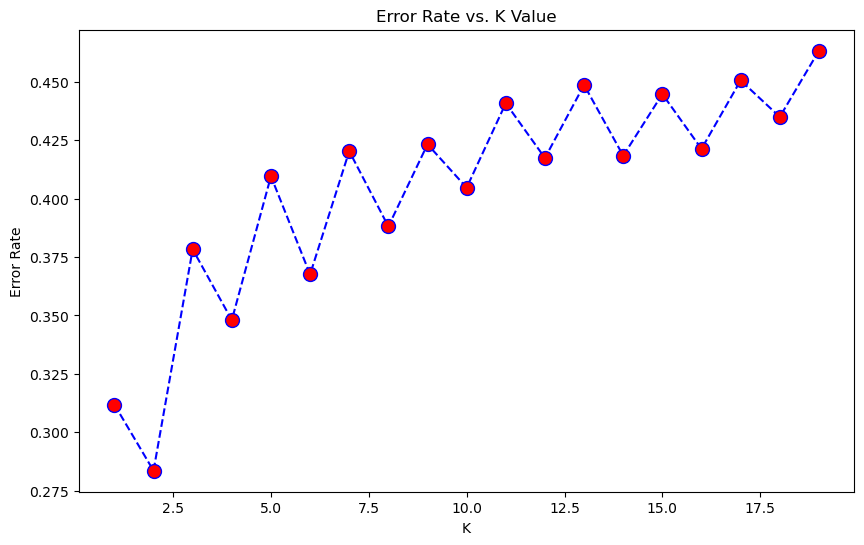

In [13]:
# Check which N_neighbors would be the best for our model based off the error rate
error_rate = []
for i in range(1,20):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train_scaled, y_resampled)
 pred_i = knn.predict(X_test_scaled)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

# Error rate code from https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb 

In [14]:
error_rate.index(min(error_rate))

1

In [15]:
# Train the K Nearest Neighbors Model
model = KNeighborsClassifier(n_neighbors =9)
model.fit(X_train_scaled, y_resampled)

KNeighborsClassifier(n_neighbors=9)

In [16]:
#Create confusion Matrix
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
   cm, index=["Actual 0", "Actual 1"],
   columns=["Predicted 0", "Predicted 1"]
)
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,484,393
Actual 1,40,106


In [17]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.55      0.69       877
           1       0.21      0.73      0.33       146

    accuracy                           0.58      1023
   macro avg       0.57      0.64      0.51      1023
weighted avg       0.82      0.58      0.64      1023

